In [94]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [95]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elytk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elytk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elytk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [96]:
# Функция для удаления ненужных символов текста
def clean_text_regex(text):
    text = re.sub(r'\n', ' ', text)
    cleaned = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', '', text)
    return cleaned.lower()

In [97]:
# Функция для лемматизации и удаления стоп-слов
def preprocess_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('russian'))
    developer_stop_words = stop_words.union({'читать', 'далее', 'всё', 'это', 'жк', 'квартира', 'дом', 'дома',
                                            'рядом', 'очень', 'ещё', 'квартиры', 'квартиру', 'пока', 'просто', 'отличный', 'хороший'})
    tokens = [word for word in tokens if word not in developer_stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [98]:
# Чтение файла с отзывами
data = pd.read_csv('reviews2.csv')

In [99]:
# Для удобства переименовываем колонку
data.rename(columns={'Отзыв': 'review'}, inplace=True)

In [100]:
# Применяем функции для предобработки текста
data['review_cleaned'] = data['review'].apply(lambda x: preprocess_text(clean_text_regex(x)))

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Векторизуем текст
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=7,
    max_df=0.9,
    ngram_range=(1, 2)
)

X_tfidf = tfidf_vectorizer.fit_transform(data['review_cleaned'])

In [120]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Уменьшаем размерность для лучшего разделения кластеров
reducer = PCA(n_components=4, random_state=42)
X_reduced = reducer.fit_transform(X_tfidf.toarray())

Кластеров: 2, Silhouette Score: 0.614
Кластеров: 3, Silhouette Score: 0.596
Кластеров: 4, Silhouette Score: 0.622
Кластеров: 5, Silhouette Score: 0.646
Кластеров: 6, Silhouette Score: 0.632
Кластеров: 7, Silhouette Score: 0.348
Кластеров: 8, Silhouette Score: 0.387
Кластеров: 9, Silhouette Score: 0.450
Кластеров: 10, Silhouette Score: 0.324


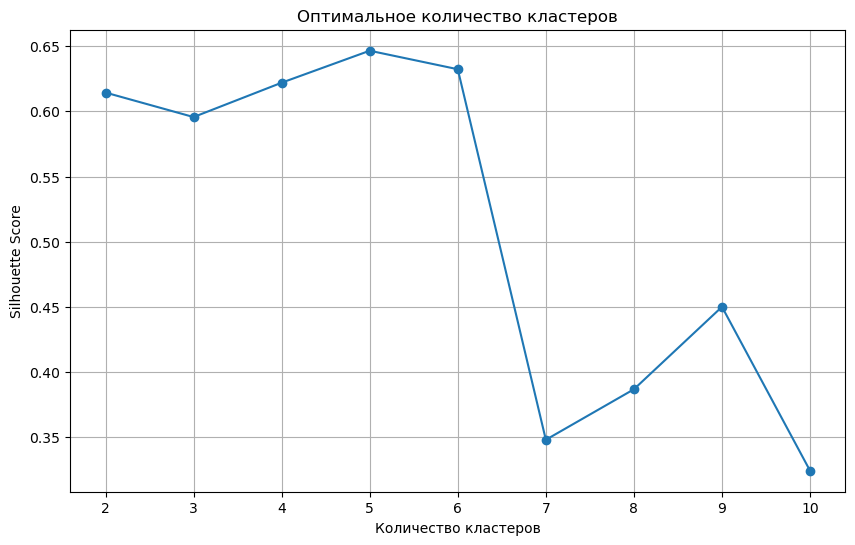

In [121]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []

# Производим подбор количества кластеров с помощью подсчета метрики
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, cluster_labels)
    silhouette_scores.append(score)
    print(f"Кластеров: {n_clusters}, Silhouette Score: {score:.3f}")
    
# Визуализация
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.grid(True)
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Оптимальное количество кластеров')
plt.show()
    
optimal_n = np.argmax(silhouette_scores) + 2

# Обучаем K-Means с оптимальным количеством кластеров
kmeans = KMeans(n_clusters=optimal_n, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(X_reduced)

In [122]:
# Функция для извлечения топа слов
def extract_key_themes(df, n_keywords=10):
    from sklearn.feature_extraction.text import CountVectorizer
    
    themes_by_cluster = {}
    
    for cluster_id in df['cluster'].unique():
        cluster_texts = df[df['cluster'] == cluster_id]['review_cleaned'].tolist()
        # Используем CountVectorizer для частотного анализа
        cv = CountVectorizer(max_features=100, ngram_range=(1, 3))
        cv_matrix = cv.fit_transform(cluster_texts)
        # Получаем частоты слов
        word_counts = cv_matrix.sum(axis=0)
        words_freq = [(word, word_counts[0, idx]) 
                     for word, idx in cv.vocabulary_.items()]
        # Сортируем по частоте
        words_freq.sort(key=lambda x: x[1], reverse=True)
        # Берем топ слов
        top_keywords = [word for word, freq in words_freq[:n_keywords]]
        themes_by_cluster[cluster_id] = top_keywords
    return themes_by_cluster

# Извлекаем ключевые темы
themes = extract_key_themes(data, n_keywords=10)
print("\nКлючевые темы по кластерам:")
for cluster_id, keywords in themes.items():
    print(f"Кластер {cluster_id}: {', '.join(keywords)}")


Ключевые темы по кластерам:
Кластер 0: застройщик, метро, проект, вид, школа, квартир, окна, двор, цены, расположение
Кластер 3: район, новый, магазины, метро, школа, красивый, инфраструктура, хорошая, тихий, уютный
Кластер 2: место, отличное, отличное место, хорошее, жизни, хорошее место, метро, тихое, прекрасное, место жизни
Кластер 1: комплекс, жилой, жилой комплекс, красивый, дворы, современный, школа, нравится, сад, инфраструктура
Кластер 4: отель, персонал, чисто, номере, номера, номер, удобное, расположение, удобное расположение, понравилось


Ключевые темы по кластерам:
Кластер 0: застройщик, метро, проект, вид, школа, квартир, окна, двор, цены, расположение. Работа: Найди оптимальный объект для вложений или безопасной покупки с ясными преимуществами.

Кластер 3: район, новый, магазины, метро, школа, красивый, инфраструктура, хорошая, тихий, уютный. Работа: Найди уже сформированный, гармоничный район для жизни "здесь и сейчас.

Кластер 2: место, отличное, отличное место, хорошее, жизни, хорошее место, метро, тихое, прекрасное, место жизни. Работа: Найди безупречное место с идеальным балансом доступности и качества среды

Кластер 1: комплекс, жилой, жилой комплекс, красивый, дворы, современный, школа, нравится, сад, инфраструктура. Работа: Найди современный, технологичный жилой комплекс как законченный продукт.

Кластер 4: отель, персонал, чисто, номере, номера, номер, удобное, расположение, удобное расположение, понравилось. Работа: Обеспечь безупречно комфортное, чистое временное проживание без хлопот, необходима не покупка квартиры, а временное проживание или покупка апартаментов в качестве инвестиции.


In [123]:
# Количество объектов в кластерах
data['cluster'].value_counts()

cluster
0    2632
2     268
3     182
1     182
4     157
Name: count, dtype: int64

Text(0.5, 1.0, 'Визуализация кластеров товаров')

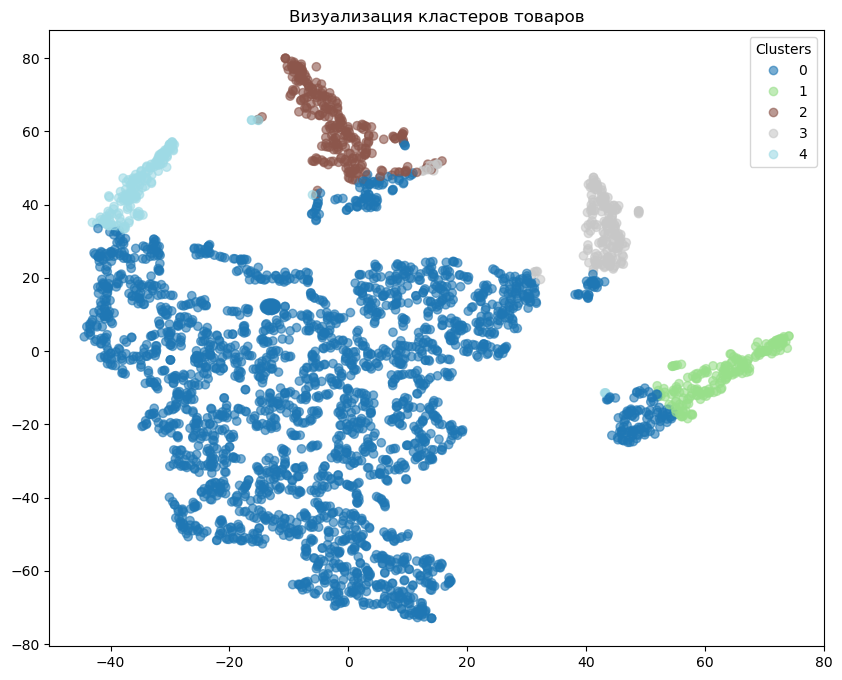

In [133]:
# Визуализация кластеров (TSNE лучше визуализирует, чем PCA)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(X_reduced)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                      c=data['cluster'], cmap='tab20', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('Визуализация кластеров товаров')